## CBAM Reimplementation for Parkinson's Handwriting

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_curve, auc
import kagglehub
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive
import random
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm
from collections import Counter


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
drive.mount('/content/drive')
print(os.listdir('/content/drive/MyDrive'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['College Application', 'Stats', 'CompSci', 'Class Materials', 'Colab Notebooks', 'Miscellaneous.gdoc', '剧本杀.gdoc']


In [4]:
base_path = '/content/drive/MyDrive/Class Materials/Fall 25/STOR566/STOR566Project/Parkinsons'

In [5]:
seed = 2025
torch.manual_seed(seed), np.random.seed(seed), random.seed(seed)

(<torch._C.Generator at 0x7a4551a62d70>, None, None)

# Dataset reformat and dataloader, 3 Fold Cross Validation


In [6]:
def handpd_loaders_with_CV(path, k = 3):

    # reformat, RGB default Normalize parameters
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.225, 0.225, 0.225])
    # input size not specified, stick with default 224 * 224
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        normalize
    ])

    full_dataset = ImageFolder(path, transform = transform)
    # 0 Heallthy and 1 patient
    labels = np.array(full_dataset.targets)

    # 80-20 split for each dataset
    train_idx, test_idx = train_test_split(
        np.arange(len(full_dataset)),
        test_size = 0.2,
        random_state = seed,
        stratify = labels)

    # form dataset
    train_dataset = Subset(full_dataset, train_idx)
    test_dataset = Subset(full_dataset, test_idx)


    #  test loaders
    test_loader  = DataLoader(test_dataset, batch_size = 32, shuffle = False, pin_memory = True)

    # properties
    print(f"Total samples: {len(full_dataset)}")
    print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")
    print(f"Classes: {full_dataset.classes}")

    # 3-fold CV
    train_labels = labels[train_idx]
    kfold = StratifiedKFold(n_splits = k, shuffle = True, random_state = seed)

    positions = np.arange(len(train_dataset))

    fold_loader = []
    for fold, (train_fold_idx, val_fold_idx) in enumerate(kfold.split(positions, train_labels)):
        train_select = Subset(train_dataset, train_fold_idx)
        val_select = Subset(train_dataset, val_fold_idx)

        train_loader = DataLoader(train_select, batch_size = 32, shuffle = True, pin_memory = True)
        val_loader = DataLoader(val_select, batch_size = 32, shuffle = True, pin_memory = True)
        fold_loader.append((train_loader, val_loader))
        print(f"Fold {fold+1}: Train {len(train_select)}, Val {len(val_select)}")

    return fold_loader, test_loader, full_dataset


In [7]:
fold_loader, test_loader, full_dataset = handpd_loaders_with_CV(base_path)

Total samples: 3264
Train samples: 2611, Test samples: 653
Classes: ['Healthy', 'Parkinson']
Fold 1: Train 1740, Val 871
Fold 2: Train 1741, Val 870
Fold 3: Train 1741, Val 870


In [8]:
counts = Counter(full_dataset.targets)
print("Class index mapping:", full_dataset.class_to_idx)
print("Total distribution:", counts)

Class index mapping: {'Healthy': 0, 'Parkinson': 1}
Total distribution: Counter({0: 1632, 1: 1632})


In [9]:
example_train, example_val = fold_loader[0]
images, labels = next(iter(example_train))
dataset = ImageFolder(base_path)
# labels -- 0(healthy) or 1(Parkinson)
print(images.shape, labels.shape)
print(dataset.classes)

torch.Size([32, 3, 224, 224]) torch.Size([32])
['Healthy', 'Parkinson']


## Visualize One Example

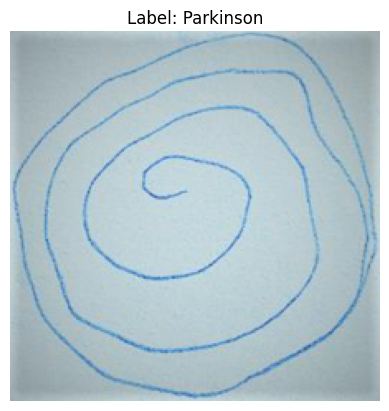

In [10]:
# Pick the first image
img = images[0]
lbl = labels[0]

# Undo normalization for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.225, 0.225, 0.225])
#transform
img = img.numpy().transpose((1, 2, 0))
img = std * img + mean
img = np.clip(img, 0, 1)
classes = dataset.classes

# Plot the image
plt.imshow(img)
plt.title(f"Label: {classes[lbl]}")
plt.axis('off')
plt.show()

# CC-NET CBAM Model Reimplementation

In [11]:
# CBAM
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio, bias = False),
            nn.ReLU(),
            nn.Linear(in_channels // ratio, in_channels, bias = False)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()

        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))

        out = avg_out + max_out
        out = self.sigmoid(out).view(b, c, 1, 1)

        return x * out


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        padding = kernel_size // 2

        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)

        out = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(out)
        out = self.sigmoid(out)

        return x * out


class CBAM(nn.Module):
    def __init__(self, channels):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        out = self.channel_attention(x)
        out = self.spatial_attention(out)
        return out


In [12]:
# CC-Net + CBAM
class CBAM_CCN(nn.Module):
  def __init__(self, num_classes = 2):
      super(CBAM_CCN, self).__init__()
    # 8 block: 2 blocks (Module A) + 3 blocks + (CBAM Module B) + 3 Output module
      self.features = nn.Sequential(
          # Module A
          # block 1, 3 * 224 * 224 -> 48 * 55 * 55
          nn.Conv2d(in_channels = 3, out_channels = 48, kernel_size = 11, stride = 4, padding = 2),
          #block 2 48 * 55 * 55 -> 128 * 27 * 27
          nn.Conv2d(in_channels = 48, out_channels = 128, kernel_size = 5, stride = 1, padding = 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),

          #Module B
          #block 3 128 * 27 * 27 --> 192 * 27 * 27
          nn.Conv2d(in_channels = 128, out_channels = 192, kernel_size = 3, stride =1, padding = 1),
          nn.ReLU(),
          # block 4 192 * 27 * 27 --> 192 * 27 * 27
          nn.Conv2d(in_channels = 192, out_channels = 192, kernel_size = 3, stride =1, padding = 1),
          nn.ReLU(),
          # block 5 192 * 27 * 27 --> 128 * 14 * 14
          nn.Conv2d(in_channels = 192, out_channels = 128, kernel_size = 3, stride = 1, padding = 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          # CBAM 128 * 14 * 14 --> 128 * 14 * 14
          CBAM(128)
          )
      self.classifier = nn.Sequential(
          #output block 6
          nn.Linear(in_features = 128 * 14 * 14, out_features = 2048),
          nn.ReLU(),
          nn.Dropout(0.5),

          # block 7
          nn.Linear(in_features = 2048, out_features = 2048),
          nn.ReLU(),
          nn.Dropout(0.5),

          # block 8
          nn.Linear(in_features = 2048, out_features = 2048),
          nn.ReLU(),
          nn.Linear(2048, num_classes)

      )

  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      return x


## CBAM Training

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cbam_model = CBAM_CCN().to(device)
print(cbam_model)

CBAM_CCN(
  (features): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): CBAM(
      (channel_attention): ChannelAttention(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (max_pool): AdaptiveMaxPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=16, bias=False)
          (1): ReLU()
          (2): Linear(in_features=16, out_features=128, bias=Fals

In [14]:
cbam_learning_rate = 1e-4
cbam_loss_fn = nn.CrossEntropyLoss()
cbam_epochs = 30

# trackers
cbam_train_loss_tracker = []
cbam_val_acc_tracker = []


for fold, (train_loader, val_loader) in enumerate(fold_loader):
  print(f"\n --- Fold {fold+1} ---")
  # reset model for each fold
  cbam_model = CBAM_CCN().to(device)
  cbam_optimizer = torch.optim.Adam(cbam_model.parameters(), lr = cbam_learning_rate)

  cbam_fold_train_loss = []
  cbam_fold_val_correct = []

  for epoch in tqdm(range(cbam_epochs)):
    cbam_model.train()
    cbam_train_sample_total = 0
    cbam_running_loss = 0.0
    # training
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      cbam_optimizer.zero_grad()
      cbam_outputs = cbam_model(images)
      cbam_loss = cbam_loss_fn(cbam_outputs, labels)
      cbam_loss.backward()
      cbam_optimizer.step()
      # store for plots
      cbam_train_sample_total += images.size(0)
      cbam_running_loss += cbam_loss.item() * images.size(0)

    cbam_epoch_train_loss = cbam_running_loss / cbam_train_sample_total
    cbam_fold_train_loss.append(cbam_epoch_train_loss)


    # validation accuracy
    cbam_model.eval()
    cbam_correct = 0
    cbam_total = 0
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = cbam_model(images)
        _,preds = torch.max(outputs, 1)
        cbam_total += labels.size(0)
        cbam_correct += (preds == labels).sum().item()
    # Output stats
    cbam_epoch_accuracy = cbam_correct / cbam_total
    cbam_fold_val_correct.append(cbam_epoch_accuracy)

    print(f"Epoch [{epoch+1}/{cbam_epochs}] - "
          f"Train Loss: {cbam_epoch_train_loss:.4f} |"
          f" Val Accuracy: {cbam_epoch_accuracy:.4f}")


  cbam_train_loss_tracker.append(cbam_fold_train_loss)
  cbam_val_acc_tracker.append(cbam_fold_val_correct)


 --- Fold 1 ---


  3%|▎         | 1/30 [00:50<24:28, 50.63s/it]

Epoch [1/30] - Train Loss: 0.6937 | Val Accuracy: 0.5006


  7%|▋         | 2/30 [01:14<16:17, 34.92s/it]

Epoch [2/30] - Train Loss: 0.6932 | Val Accuracy: 0.5006


 10%|█         | 3/30 [01:39<13:35, 30.19s/it]

Epoch [3/30] - Train Loss: 0.6888 | Val Accuracy: 0.4994


 13%|█▎        | 4/30 [02:03<12:03, 27.83s/it]

Epoch [4/30] - Train Loss: 0.6781 | Val Accuracy: 0.5465


 17%|█▋        | 5/30 [02:27<10:59, 26.38s/it]

Epoch [5/30] - Train Loss: 0.6717 | Val Accuracy: 0.6142


 20%|██        | 6/30 [02:50<10:07, 25.32s/it]

Epoch [6/30] - Train Loss: 0.6255 | Val Accuracy: 0.6016


 23%|██▎       | 7/30 [03:14<09:31, 24.84s/it]

Epoch [7/30] - Train Loss: 0.5920 | Val Accuracy: 0.6808


 27%|██▋       | 8/30 [03:38<09:00, 24.56s/it]

Epoch [8/30] - Train Loss: 0.4986 | Val Accuracy: 0.7532


 30%|███       | 9/30 [04:02<08:31, 24.34s/it]

Epoch [9/30] - Train Loss: 0.4329 | Val Accuracy: 0.8071


 33%|███▎      | 10/30 [04:26<08:04, 24.23s/it]

Epoch [10/30] - Train Loss: 0.3859 | Val Accuracy: 0.7922


 37%|███▋      | 11/30 [04:49<07:35, 23.95s/it]

Epoch [11/30] - Train Loss: 0.3278 | Val Accuracy: 0.8416


 40%|████      | 12/30 [05:12<07:08, 23.82s/it]

Epoch [12/30] - Train Loss: 0.2654 | Val Accuracy: 0.8507


 43%|████▎     | 13/30 [05:36<06:44, 23.82s/it]

Epoch [13/30] - Train Loss: 0.2161 | Val Accuracy: 0.8691


 47%|████▋     | 14/30 [06:00<06:20, 23.80s/it]

Epoch [14/30] - Train Loss: 0.1471 | Val Accuracy: 0.8829


 50%|█████     | 15/30 [06:24<05:56, 23.79s/it]

Epoch [15/30] - Train Loss: 0.0964 | Val Accuracy: 0.9127


 53%|█████▎    | 16/30 [06:47<05:31, 23.69s/it]

Epoch [16/30] - Train Loss: 0.0934 | Val Accuracy: 0.9070


 57%|█████▋    | 17/30 [07:11<05:07, 23.63s/it]

Epoch [17/30] - Train Loss: 0.0609 | Val Accuracy: 0.9288


 60%|██████    | 18/30 [07:34<04:43, 23.64s/it]

Epoch [18/30] - Train Loss: 0.0650 | Val Accuracy: 0.9082


 63%|██████▎   | 19/30 [07:58<04:20, 23.67s/it]

Epoch [19/30] - Train Loss: 0.0466 | Val Accuracy: 0.9208


 67%|██████▋   | 20/30 [08:22<03:57, 23.72s/it]

Epoch [20/30] - Train Loss: 0.0368 | Val Accuracy: 0.9127


 70%|███████   | 21/30 [08:45<03:32, 23.65s/it]

Epoch [21/30] - Train Loss: 0.0128 | Val Accuracy: 0.9300


 73%|███████▎  | 22/30 [09:09<03:07, 23.49s/it]

Epoch [22/30] - Train Loss: 0.0124 | Val Accuracy: 0.9127


 77%|███████▋  | 23/30 [09:32<02:44, 23.51s/it]

Epoch [23/30] - Train Loss: 0.0264 | Val Accuracy: 0.9082


 80%|████████  | 24/30 [09:56<02:21, 23.62s/it]

Epoch [24/30] - Train Loss: 0.0131 | Val Accuracy: 0.9357


 83%|████████▎ | 25/30 [10:20<01:58, 23.65s/it]

Epoch [25/30] - Train Loss: 0.0038 | Val Accuracy: 0.9311


 87%|████████▋ | 26/30 [10:43<01:34, 23.62s/it]

Epoch [26/30] - Train Loss: 0.0153 | Val Accuracy: 0.9277


 90%|█████████ | 27/30 [11:07<01:10, 23.53s/it]

Epoch [27/30] - Train Loss: 0.0252 | Val Accuracy: 0.9219


 93%|█████████▎| 28/30 [11:30<00:47, 23.56s/it]

Epoch [28/30] - Train Loss: 0.0041 | Val Accuracy: 0.9265


 97%|█████████▋| 29/30 [11:54<00:23, 23.66s/it]

Epoch [29/30] - Train Loss: 0.0039 | Val Accuracy: 0.9323


100%|██████████| 30/30 [12:18<00:00, 24.62s/it]

Epoch [30/30] - Train Loss: 0.0108 | Val Accuracy: 0.9116

 --- Fold 2 ---



  3%|▎         | 1/30 [00:24<11:36, 24.01s/it]

Epoch [1/30] - Train Loss: 0.6941 | Val Accuracy: 0.5000


  7%|▋         | 2/30 [00:47<11:01, 23.63s/it]

Epoch [2/30] - Train Loss: 0.6936 | Val Accuracy: 0.5000


 10%|█         | 3/30 [01:10<10:36, 23.57s/it]

Epoch [3/30] - Train Loss: 0.6920 | Val Accuracy: 0.5000


 13%|█▎        | 4/30 [01:34<10:15, 23.65s/it]

Epoch [4/30] - Train Loss: 0.6933 | Val Accuracy: 0.5000


 17%|█▋        | 5/30 [01:58<09:53, 23.73s/it]

Epoch [5/30] - Train Loss: 0.6820 | Val Accuracy: 0.5828


 20%|██        | 6/30 [02:22<09:30, 23.79s/it]

Epoch [6/30] - Train Loss: 0.6818 | Val Accuracy: 0.5805


 23%|██▎       | 7/30 [02:46<09:06, 23.75s/it]

Epoch [7/30] - Train Loss: 0.6682 | Val Accuracy: 0.5839


 27%|██▋       | 8/30 [03:09<08:39, 23.62s/it]

Epoch [8/30] - Train Loss: 0.6503 | Val Accuracy: 0.6299


 30%|███       | 9/30 [03:33<08:17, 23.67s/it]

Epoch [9/30] - Train Loss: 0.6483 | Val Accuracy: 0.6575


 33%|███▎      | 10/30 [03:57<07:57, 23.90s/it]

Epoch [10/30] - Train Loss: 0.6498 | Val Accuracy: 0.5713


 37%|███▋      | 11/30 [04:21<07:35, 23.97s/it]

Epoch [11/30] - Train Loss: 0.6316 | Val Accuracy: 0.6805


 40%|████      | 12/30 [04:46<07:14, 24.16s/it]

Epoch [12/30] - Train Loss: 0.5768 | Val Accuracy: 0.6931


 43%|████▎     | 13/30 [05:10<06:50, 24.18s/it]

Epoch [13/30] - Train Loss: 0.5253 | Val Accuracy: 0.7310


 47%|████▋     | 14/30 [05:34<06:23, 24.00s/it]

Epoch [14/30] - Train Loss: 0.4584 | Val Accuracy: 0.7724


 50%|█████     | 15/30 [05:57<05:58, 23.93s/it]

Epoch [15/30] - Train Loss: 0.3684 | Val Accuracy: 0.7644


 53%|█████▎    | 16/30 [06:21<05:34, 23.88s/it]

Epoch [16/30] - Train Loss: 0.3124 | Val Accuracy: 0.8218


 57%|█████▋    | 17/30 [06:45<05:10, 23.89s/it]

Epoch [17/30] - Train Loss: 0.2141 | Val Accuracy: 0.8759


 60%|██████    | 18/30 [07:09<04:47, 23.94s/it]

Epoch [18/30] - Train Loss: 0.1670 | Val Accuracy: 0.8782


 63%|██████▎   | 19/30 [07:33<04:22, 23.84s/it]

Epoch [19/30] - Train Loss: 0.1374 | Val Accuracy: 0.8448


 67%|██████▋   | 20/30 [07:57<03:58, 23.86s/it]

Epoch [20/30] - Train Loss: 0.0733 | Val Accuracy: 0.8989


 70%|███████   | 21/30 [08:21<03:35, 23.91s/it]

Epoch [21/30] - Train Loss: 0.0410 | Val Accuracy: 0.9080


 73%|███████▎  | 22/30 [08:45<03:12, 24.02s/it]

Epoch [22/30] - Train Loss: 0.0619 | Val Accuracy: 0.8885


 77%|███████▋  | 23/30 [09:09<02:48, 24.11s/it]

Epoch [23/30] - Train Loss: 0.0373 | Val Accuracy: 0.9149


 80%|████████  | 24/30 [09:34<02:24, 24.15s/it]

Epoch [24/30] - Train Loss: 0.0361 | Val Accuracy: 0.8931


 83%|████████▎ | 25/30 [09:58<02:00, 24.17s/it]

Epoch [25/30] - Train Loss: 0.0246 | Val Accuracy: 0.9138


 87%|████████▋ | 26/30 [10:21<01:36, 24.03s/it]

Epoch [26/30] - Train Loss: 0.0520 | Val Accuracy: 0.9080


 90%|█████████ | 27/30 [10:45<01:11, 23.92s/it]

Epoch [27/30] - Train Loss: 0.0364 | Val Accuracy: 0.9161


 93%|█████████▎| 28/30 [11:09<00:47, 23.94s/it]

Epoch [28/30] - Train Loss: 0.0170 | Val Accuracy: 0.9115


 97%|█████████▋| 29/30 [11:33<00:23, 23.88s/it]

Epoch [29/30] - Train Loss: 0.0106 | Val Accuracy: 0.9172


100%|██████████| 30/30 [11:57<00:00, 23.91s/it]

Epoch [30/30] - Train Loss: 0.0053 | Val Accuracy: 0.9149

 --- Fold 3 ---



  3%|▎         | 1/30 [00:24<11:36, 24.01s/it]

Epoch [1/30] - Train Loss: 0.6938 | Val Accuracy: 0.5000


  7%|▋         | 2/30 [00:47<11:05, 23.77s/it]

Epoch [2/30] - Train Loss: 0.6942 | Val Accuracy: 0.5000


 10%|█         | 3/30 [01:11<10:48, 24.01s/it]

Epoch [3/30] - Train Loss: 0.6920 | Val Accuracy: 0.5034


 13%|█▎        | 4/30 [01:35<10:22, 23.95s/it]

Epoch [4/30] - Train Loss: 0.6790 | Val Accuracy: 0.5805


 17%|█▋        | 5/30 [01:59<09:58, 23.93s/it]

Epoch [5/30] - Train Loss: 0.6665 | Val Accuracy: 0.5931


 20%|██        | 6/30 [02:23<09:33, 23.90s/it]

Epoch [6/30] - Train Loss: 0.6364 | Val Accuracy: 0.6172


 23%|██▎       | 7/30 [02:47<09:08, 23.85s/it]

Epoch [7/30] - Train Loss: 0.6308 | Val Accuracy: 0.6736


 27%|██▋       | 8/30 [03:10<08:40, 23.67s/it]

Epoch [8/30] - Train Loss: 0.5502 | Val Accuracy: 0.7138


 30%|███       | 9/30 [03:34<08:19, 23.79s/it]

Epoch [9/30] - Train Loss: 0.4924 | Val Accuracy: 0.7115


 33%|███▎      | 10/30 [03:58<07:56, 23.82s/it]

Epoch [10/30] - Train Loss: 0.4226 | Val Accuracy: 0.7747


 37%|███▋      | 11/30 [04:22<07:33, 23.89s/it]

Epoch [11/30] - Train Loss: 0.3569 | Val Accuracy: 0.8115


 40%|████      | 12/30 [04:46<07:10, 23.93s/it]

Epoch [12/30] - Train Loss: 0.2892 | Val Accuracy: 0.7977


 43%|████▎     | 13/30 [05:10<06:44, 23.79s/it]

Epoch [13/30] - Train Loss: 0.2375 | Val Accuracy: 0.8241


 47%|████▋     | 14/30 [05:33<06:20, 23.80s/it]

Epoch [14/30] - Train Loss: 0.1972 | Val Accuracy: 0.8437


 50%|█████     | 15/30 [05:57<05:57, 23.82s/it]

Epoch [15/30] - Train Loss: 0.1217 | Val Accuracy: 0.8644


 53%|█████▎    | 16/30 [06:21<05:33, 23.85s/it]

Epoch [16/30] - Train Loss: 0.0964 | Val Accuracy: 0.8908


 57%|█████▋    | 17/30 [06:45<05:11, 23.94s/it]

Epoch [17/30] - Train Loss: 0.0882 | Val Accuracy: 0.8816


 60%|██████    | 18/30 [07:10<04:49, 24.11s/it]

Epoch [18/30] - Train Loss: 0.0828 | Val Accuracy: 0.8943


 63%|██████▎   | 19/30 [07:34<04:23, 23.99s/it]

Epoch [19/30] - Train Loss: 0.0554 | Val Accuracy: 0.9023


 67%|██████▋   | 20/30 [07:57<03:59, 23.98s/it]

Epoch [20/30] - Train Loss: 0.0338 | Val Accuracy: 0.9115


 70%|███████   | 21/30 [08:21<03:35, 23.96s/it]

Epoch [21/30] - Train Loss: 0.0125 | Val Accuracy: 0.9011


 73%|███████▎  | 22/30 [08:46<03:12, 24.11s/it]

Epoch [22/30] - Train Loss: 0.0195 | Val Accuracy: 0.8943


 77%|███████▋  | 23/30 [09:10<02:48, 24.12s/it]

Epoch [23/30] - Train Loss: 0.0359 | Val Accuracy: 0.8989


 80%|████████  | 24/30 [09:34<02:24, 24.03s/it]

Epoch [24/30] - Train Loss: 0.0310 | Val Accuracy: 0.9149


 83%|████████▎ | 25/30 [09:57<01:58, 23.80s/it]

Epoch [25/30] - Train Loss: 0.0271 | Val Accuracy: 0.8943


 87%|████████▋ | 26/30 [10:21<01:34, 23.71s/it]

Epoch [26/30] - Train Loss: 0.0184 | Val Accuracy: 0.9126


 90%|█████████ | 27/30 [10:44<01:11, 23.69s/it]

Epoch [27/30] - Train Loss: 0.0080 | Val Accuracy: 0.9172


 93%|█████████▎| 28/30 [11:08<00:47, 23.68s/it]

Epoch [28/30] - Train Loss: 0.0017 | Val Accuracy: 0.9195


 97%|█████████▋| 29/30 [11:31<00:23, 23.66s/it]

Epoch [29/30] - Train Loss: 0.0004 | Val Accuracy: 0.9218


100%|██████████| 30/30 [11:55<00:00, 23.84s/it]

Epoch [30/30] - Train Loss: 0.0006 | Val Accuracy: 0.9207


# CC-NET Reimplementation

In [15]:
class handpd_ccnet(nn.Module):
  def __init__(self, num_classes = 2):
    super(handpd_ccnet, self).__init__()

    self.classifier = nn.Sequential(
        # module A
        # layer 1, 227 -> 56
        nn.Conv2d(in_channels = 3, out_channels = 48, kernel_size = 11, stride = 4, padding = 2),
        nn.ReLU(),
        #layer 2 56 -> 28
        nn.Conv2d(in_channels = 48, out_channels = 128, kernel_size = 5, stride = 2, padding = 2),
        nn.ReLU(),
        #Layer 3 28 -> 9
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 3),

        #module B
        #layer 1 9 -> 9
        nn.Conv2d(in_channels = 128, out_channels = 192, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        #layer 2 9 -> 9
        nn.Conv2d(in_channels = 192, out_channels = 192, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        # layer 3 9 -> 5 -> 1
        nn.Conv2d(in_channels = 192, out_channels = 128, kernel_size = 3, stride = 2, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride = 3),

        # optional since 1*1
        nn.Flatten(),
        # FC
        nn.Linear(in_features = 128 * 1 * 1, out_features = num_classes)
        )

  def forward(self, x):
    return self.classifier(x)



## CCNET Training

In [16]:
cc_net_model = handpd_ccnet().to(device)
print(cc_net_model)

handpd_ccnet(
  (classifier): Sequential(
    (0): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(48, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(192, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [17]:
ccnet_lr = 1e-4
ccnet_epoch = 50
ccnet_loss_fn = nn.CrossEntropyLoss()


# trackers
ccnet_train_loss_tracker = []
ccnet_val_acc_tracker = []

for fold, (train_loader, val_loader) in enumerate(fold_loader):
  print(f"\n --- Fold {fold+1} ---")
  # reset for each fold
  cc_net_model = handpd_ccnet().to(device)
  ccnet_optimizer = optim.Adam(cc_net_model.parameters(), lr = ccnet_lr)
  ccnet_fold_train_loss = []
  ccnet_fold_val_correct = []

  for epoch in tqdm(range(ccnet_epoch)):
    cc_net_model.train()
    ccnet_train_sample_total = 0
    ccnet_running_loss = 0.0
    # training
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      ccnet_optimizer.zero_grad()
      ccnet_outputs = cc_net_model(images)
      ccnet_loss = ccnet_loss_fn(ccnet_outputs, labels)
      ccnet_loss.backward()
      ccnet_optimizer.step()
      # store for plots
      ccnet_train_sample_total += images.size(0)
      ccnet_running_loss += ccnet_loss.item() * images.size(0)

    ccnet_epoch_train_loss = ccnet_running_loss / ccnet_train_sample_total
    ccnet_fold_train_loss.append(ccnet_epoch_train_loss)


    # validation accuracy
    cc_net_model.eval()
    ccnet_correct = 0
    ccnet_total = 0
    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        ccnet_outputs = cc_net_model(images)
        _,preds = torch.max(ccnet_outputs, 1)
        ccnet_total += labels.size(0)
        ccnet_correct += (preds == labels).sum().item()
    # Output stats
    ccnet_epoch_accuracy = ccnet_correct / ccnet_total
    ccnet_fold_val_correct.append(ccnet_epoch_accuracy)

    print(f"Epoch [{epoch+1}/{ccnet_epoch}] - Train Loss: {ccnet_epoch_train_loss:.4f} | Val Accuracy: {ccnet_epoch_accuracy:.4f}")


  ccnet_train_loss_tracker.append(ccnet_fold_train_loss)
  ccnet_val_acc_tracker.append(ccnet_fold_val_correct)



 --- Fold 1 ---


  2%|▏         | 1/50 [00:20<17:01, 20.84s/it]

Epoch [1/50] - Train Loss: 0.6933 | Val Accuracy: 0.5155


  4%|▍         | 2/50 [00:41<16:45, 20.94s/it]

Epoch [2/50] - Train Loss: 0.6921 | Val Accuracy: 0.5385


  6%|▌         | 3/50 [01:02<16:08, 20.61s/it]

Epoch [3/50] - Train Loss: 0.6821 | Val Accuracy: 0.5006


  8%|▊         | 4/50 [01:22<15:52, 20.70s/it]

Epoch [4/50] - Train Loss: 0.6764 | Val Accuracy: 0.5522


 10%|█         | 5/50 [01:43<15:23, 20.52s/it]

Epoch [5/50] - Train Loss: 0.6743 | Val Accuracy: 0.5212


 12%|█▏        | 6/50 [02:04<15:13, 20.75s/it]

Epoch [6/50] - Train Loss: 0.6772 | Val Accuracy: 0.5626


 14%|█▍        | 7/50 [02:24<14:49, 20.68s/it]

Epoch [7/50] - Train Loss: 0.6559 | Val Accuracy: 0.5431


 16%|█▌        | 8/50 [02:45<14:26, 20.63s/it]

Epoch [8/50] - Train Loss: 0.6660 | Val Accuracy: 0.5913


 18%|█▊        | 9/50 [03:06<14:10, 20.74s/it]

Epoch [9/50] - Train Loss: 0.6276 | Val Accuracy: 0.6257


 20%|██        | 10/50 [03:26<13:43, 20.59s/it]

Epoch [10/50] - Train Loss: 0.6130 | Val Accuracy: 0.6361


 22%|██▏       | 11/50 [03:47<13:24, 20.62s/it]

Epoch [11/50] - Train Loss: 0.5974 | Val Accuracy: 0.6211


 24%|██▍       | 12/50 [04:07<12:57, 20.45s/it]

Epoch [12/50] - Train Loss: 0.5728 | Val Accuracy: 0.6533


 26%|██▌       | 13/50 [04:28<12:40, 20.56s/it]

Epoch [13/50] - Train Loss: 0.5540 | Val Accuracy: 0.6912


 28%|██▊       | 14/50 [04:48<12:18, 20.52s/it]

Epoch [14/50] - Train Loss: 0.5292 | Val Accuracy: 0.6315


 30%|███       | 15/50 [05:09<11:57, 20.50s/it]

Epoch [15/50] - Train Loss: 0.5267 | Val Accuracy: 0.6980


 32%|███▏      | 16/50 [05:30<11:42, 20.67s/it]

Epoch [16/50] - Train Loss: 0.5099 | Val Accuracy: 0.6728


 34%|███▍      | 17/50 [05:50<11:16, 20.49s/it]

Epoch [17/50] - Train Loss: 0.4730 | Val Accuracy: 0.7141


 36%|███▌      | 18/50 [06:11<10:59, 20.61s/it]

Epoch [18/50] - Train Loss: 0.4396 | Val Accuracy: 0.7095


 38%|███▊      | 19/50 [06:31<10:35, 20.52s/it]

Epoch [19/50] - Train Loss: 0.4266 | Val Accuracy: 0.7371


 40%|████      | 20/50 [06:52<10:21, 20.71s/it]

Epoch [20/50] - Train Loss: 0.3802 | Val Accuracy: 0.7348


 42%|████▏     | 21/50 [07:13<10:02, 20.78s/it]

Epoch [21/50] - Train Loss: 0.3462 | Val Accuracy: 0.7463


 44%|████▍     | 22/50 [07:33<09:38, 20.65s/it]

Epoch [22/50] - Train Loss: 0.3298 | Val Accuracy: 0.7336


 46%|████▌     | 23/50 [07:54<09:21, 20.79s/it]

Epoch [23/50] - Train Loss: 0.2844 | Val Accuracy: 0.7509


 48%|████▊     | 24/50 [08:15<08:57, 20.67s/it]

Epoch [24/50] - Train Loss: 0.2857 | Val Accuracy: 0.7509


 50%|█████     | 25/50 [08:36<08:39, 20.76s/it]

Epoch [25/50] - Train Loss: 0.2333 | Val Accuracy: 0.7440


 52%|█████▏    | 26/50 [08:56<08:15, 20.65s/it]

Epoch [26/50] - Train Loss: 0.2019 | Val Accuracy: 0.7623


 54%|█████▍    | 27/50 [09:17<07:55, 20.69s/it]

Epoch [27/50] - Train Loss: 0.1627 | Val Accuracy: 0.7773


 56%|█████▌    | 28/50 [09:38<07:36, 20.76s/it]

Epoch [28/50] - Train Loss: 0.1478 | Val Accuracy: 0.7819


 58%|█████▊    | 29/50 [09:58<07:12, 20.57s/it]

Epoch [29/50] - Train Loss: 0.1228 | Val Accuracy: 0.7899


 60%|██████    | 30/50 [10:19<06:53, 20.70s/it]

Epoch [30/50] - Train Loss: 0.0990 | Val Accuracy: 0.7933


 62%|██████▏   | 31/50 [10:39<06:31, 20.62s/it]

Epoch [31/50] - Train Loss: 0.0853 | Val Accuracy: 0.8094


 64%|██████▍   | 32/50 [11:01<06:13, 20.75s/it]

Epoch [32/50] - Train Loss: 0.0580 | Val Accuracy: 0.8002


 66%|██████▌   | 33/50 [11:21<05:51, 20.68s/it]

Epoch [33/50] - Train Loss: 0.0536 | Val Accuracy: 0.8197


 68%|██████▊   | 34/50 [11:41<05:29, 20.60s/it]

Epoch [34/50] - Train Loss: 0.0463 | Val Accuracy: 0.8060


 70%|███████   | 35/50 [12:02<05:10, 20.70s/it]

Epoch [35/50] - Train Loss: 0.0235 | Val Accuracy: 0.8117


 72%|███████▏  | 36/50 [12:23<04:48, 20.58s/it]

Epoch [36/50] - Train Loss: 0.0125 | Val Accuracy: 0.8106


 74%|███████▍  | 37/50 [12:43<04:27, 20.61s/it]

Epoch [37/50] - Train Loss: 0.0088 | Val Accuracy: 0.8083


 76%|███████▌  | 38/50 [13:03<04:05, 20.46s/it]

Epoch [38/50] - Train Loss: 0.0070 | Val Accuracy: 0.8048


 78%|███████▊  | 39/50 [13:24<03:46, 20.56s/it]

Epoch [39/50] - Train Loss: 0.0071 | Val Accuracy: 0.8117


 80%|████████  | 40/50 [13:45<03:25, 20.51s/it]

Epoch [40/50] - Train Loss: 0.0056 | Val Accuracy: 0.8094


 82%|████████▏ | 41/50 [14:05<03:04, 20.51s/it]

Epoch [41/50] - Train Loss: 0.0043 | Val Accuracy: 0.8129


 84%|████████▍ | 42/50 [14:26<02:44, 20.57s/it]

Epoch [42/50] - Train Loss: 0.0031 | Val Accuracy: 0.8140


 86%|████████▌ | 43/50 [14:46<02:22, 20.39s/it]

Epoch [43/50] - Train Loss: 0.0025 | Val Accuracy: 0.8175


 88%|████████▊ | 44/50 [15:07<02:03, 20.52s/it]

Epoch [44/50] - Train Loss: 0.0019 | Val Accuracy: 0.8163


 90%|█████████ | 45/50 [15:27<01:41, 20.36s/it]

Epoch [45/50] - Train Loss: 0.0017 | Val Accuracy: 0.8163


 92%|█████████▏| 46/50 [15:47<01:21, 20.44s/it]

Epoch [46/50] - Train Loss: 0.0016 | Val Accuracy: 0.8152


 94%|█████████▍| 47/50 [16:07<01:01, 20.33s/it]

Epoch [47/50] - Train Loss: 0.0014 | Val Accuracy: 0.8140


 96%|█████████▌| 48/50 [16:28<00:40, 20.44s/it]

Epoch [48/50] - Train Loss: 0.0012 | Val Accuracy: 0.8163


 98%|█████████▊| 49/50 [16:49<00:20, 20.52s/it]

Epoch [49/50] - Train Loss: 0.0011 | Val Accuracy: 0.8186


100%|██████████| 50/50 [17:09<00:00, 20.59s/it]


Epoch [50/50] - Train Loss: 0.0010 | Val Accuracy: 0.8186

 --- Fold 2 ---


  2%|▏         | 1/50 [00:21<17:16, 21.15s/it]

Epoch [1/50] - Train Loss: 0.6942 | Val Accuracy: 0.5000


  4%|▍         | 2/50 [00:41<16:28, 20.60s/it]

Epoch [2/50] - Train Loss: 0.6940 | Val Accuracy: 0.5000


  6%|▌         | 3/50 [01:02<16:08, 20.62s/it]

Epoch [3/50] - Train Loss: 0.6935 | Val Accuracy: 0.5000


  8%|▊         | 4/50 [01:21<15:35, 20.34s/it]

Epoch [4/50] - Train Loss: 0.6921 | Val Accuracy: 0.5000


 10%|█         | 5/50 [01:42<15:21, 20.47s/it]

Epoch [5/50] - Train Loss: 0.6839 | Val Accuracy: 0.5759


 12%|█▏        | 6/50 [02:03<15:02, 20.50s/it]

Epoch [6/50] - Train Loss: 0.6508 | Val Accuracy: 0.6172


 14%|█▍        | 7/50 [02:23<14:41, 20.50s/it]

Epoch [7/50] - Train Loss: 0.6437 | Val Accuracy: 0.6241


 16%|█▌        | 8/50 [02:44<14:24, 20.58s/it]

Epoch [8/50] - Train Loss: 0.6051 | Val Accuracy: 0.6126


 18%|█▊        | 9/50 [03:04<13:57, 20.43s/it]

Epoch [9/50] - Train Loss: 0.5870 | Val Accuracy: 0.6621


 20%|██        | 10/50 [03:25<13:44, 20.61s/it]

Epoch [10/50] - Train Loss: 0.5709 | Val Accuracy: 0.6644


 22%|██▏       | 11/50 [03:45<13:16, 20.41s/it]

Epoch [11/50] - Train Loss: 0.5403 | Val Accuracy: 0.7000


 24%|██▍       | 12/50 [04:06<12:59, 20.52s/it]

Epoch [12/50] - Train Loss: 0.5178 | Val Accuracy: 0.7184


 26%|██▌       | 13/50 [04:26<12:39, 20.54s/it]

Epoch [13/50] - Train Loss: 0.5044 | Val Accuracy: 0.7161


 28%|██▊       | 14/50 [04:47<12:18, 20.51s/it]

Epoch [14/50] - Train Loss: 0.4754 | Val Accuracy: 0.7172


 30%|███       | 15/50 [05:08<12:01, 20.62s/it]

Epoch [15/50] - Train Loss: 0.4508 | Val Accuracy: 0.7103


 32%|███▏      | 16/50 [05:28<11:39, 20.57s/it]

Epoch [16/50] - Train Loss: 0.4299 | Val Accuracy: 0.7368


 34%|███▍      | 17/50 [05:49<11:22, 20.68s/it]

Epoch [17/50] - Train Loss: 0.4023 | Val Accuracy: 0.7184


 36%|███▌      | 18/50 [06:09<10:55, 20.49s/it]

Epoch [18/50] - Train Loss: 0.3907 | Val Accuracy: 0.7276


 38%|███▊      | 19/50 [06:30<10:38, 20.60s/it]

Epoch [19/50] - Train Loss: 0.3575 | Val Accuracy: 0.7621


 40%|████      | 20/50 [06:50<10:17, 20.58s/it]

Epoch [20/50] - Train Loss: 0.3288 | Val Accuracy: 0.7609


 42%|████▏     | 21/50 [07:11<09:53, 20.48s/it]

Epoch [21/50] - Train Loss: 0.3086 | Val Accuracy: 0.7667


 44%|████▍     | 22/50 [07:32<09:37, 20.62s/it]

Epoch [22/50] - Train Loss: 0.2576 | Val Accuracy: 0.7805


 46%|████▌     | 23/50 [07:52<09:13, 20.50s/it]

Epoch [23/50] - Train Loss: 0.2445 | Val Accuracy: 0.7747


 48%|████▊     | 24/50 [08:13<08:54, 20.57s/it]

Epoch [24/50] - Train Loss: 0.2158 | Val Accuracy: 0.7977


 50%|█████     | 25/50 [08:33<08:30, 20.43s/it]

Epoch [25/50] - Train Loss: 0.1737 | Val Accuracy: 0.7839


 52%|█████▏    | 26/50 [08:54<08:14, 20.60s/it]

Epoch [26/50] - Train Loss: 0.1514 | Val Accuracy: 0.8287


 54%|█████▍    | 27/50 [09:15<07:55, 20.69s/it]

Epoch [27/50] - Train Loss: 0.1264 | Val Accuracy: 0.7770


 56%|█████▌    | 28/50 [09:35<07:33, 20.61s/it]

Epoch [28/50] - Train Loss: 0.1212 | Val Accuracy: 0.8103


 58%|█████▊    | 29/50 [09:56<07:14, 20.68s/it]

Epoch [29/50] - Train Loss: 0.0818 | Val Accuracy: 0.8230


 60%|██████    | 30/50 [10:16<06:50, 20.53s/it]

Epoch [30/50] - Train Loss: 0.0582 | Val Accuracy: 0.8287


 62%|██████▏   | 31/50 [10:37<06:34, 20.77s/it]

Epoch [31/50] - Train Loss: 0.0415 | Val Accuracy: 0.8195


 64%|██████▍   | 32/50 [10:58<06:11, 20.64s/it]

Epoch [32/50] - Train Loss: 0.0347 | Val Accuracy: 0.7966


 66%|██████▌   | 33/50 [11:19<05:51, 20.69s/it]

Epoch [33/50] - Train Loss: 0.0455 | Val Accuracy: 0.8253


 68%|██████▊   | 34/50 [11:39<05:32, 20.75s/it]

Epoch [34/50] - Train Loss: 0.0270 | Val Accuracy: 0.8218


 70%|███████   | 35/50 [12:00<05:09, 20.63s/it]

Epoch [35/50] - Train Loss: 0.0204 | Val Accuracy: 0.8345


 72%|███████▏  | 36/50 [12:21<04:49, 20.70s/it]

Epoch [36/50] - Train Loss: 0.0102 | Val Accuracy: 0.8299


 74%|███████▍  | 37/50 [12:41<04:27, 20.56s/it]

Epoch [37/50] - Train Loss: 0.0061 | Val Accuracy: 0.8356


 76%|███████▌  | 38/50 [13:02<04:07, 20.63s/it]

Epoch [38/50] - Train Loss: 0.0048 | Val Accuracy: 0.8333


 78%|███████▊  | 39/50 [13:23<03:49, 20.84s/it]

Epoch [39/50] - Train Loss: 0.0037 | Val Accuracy: 0.8333


 80%|████████  | 40/50 [13:44<03:28, 20.84s/it]

Epoch [40/50] - Train Loss: 0.0033 | Val Accuracy: 0.8356


 82%|████████▏ | 41/50 [14:05<03:08, 20.97s/it]

Epoch [41/50] - Train Loss: 0.0024 | Val Accuracy: 0.8287


 84%|████████▍ | 42/50 [14:26<02:46, 20.84s/it]

Epoch [42/50] - Train Loss: 0.0021 | Val Accuracy: 0.8368


 86%|████████▌ | 43/50 [14:47<02:26, 20.87s/it]

Epoch [43/50] - Train Loss: 0.0018 | Val Accuracy: 0.8310


 88%|████████▊ | 44/50 [15:07<02:04, 20.67s/it]

Epoch [44/50] - Train Loss: 0.0016 | Val Accuracy: 0.8414


 90%|█████████ | 45/50 [15:27<01:43, 20.67s/it]

Epoch [45/50] - Train Loss: 0.0014 | Val Accuracy: 0.8368


 92%|█████████▏| 46/50 [15:49<01:23, 20.82s/it]

Epoch [46/50] - Train Loss: 0.0013 | Val Accuracy: 0.8368


 94%|█████████▍| 47/50 [16:09<01:01, 20.60s/it]

Epoch [47/50] - Train Loss: 0.0012 | Val Accuracy: 0.8356


 96%|█████████▌| 48/50 [16:30<00:41, 20.77s/it]

Epoch [48/50] - Train Loss: 0.0011 | Val Accuracy: 0.8402


 98%|█████████▊| 49/50 [16:50<00:20, 20.59s/it]

Epoch [49/50] - Train Loss: 0.0010 | Val Accuracy: 0.8379


100%|██████████| 50/50 [17:11<00:00, 20.63s/it]


Epoch [50/50] - Train Loss: 0.0009 | Val Accuracy: 0.8287

 --- Fold 3 ---


  2%|▏         | 1/50 [00:20<16:37, 20.36s/it]

Epoch [1/50] - Train Loss: 0.6944 | Val Accuracy: 0.5000


  4%|▍         | 2/50 [00:41<16:27, 20.57s/it]

Epoch [2/50] - Train Loss: 0.6938 | Val Accuracy: 0.5000


  6%|▌         | 3/50 [01:01<16:11, 20.68s/it]

Epoch [3/50] - Train Loss: 0.6921 | Val Accuracy: 0.5425


  8%|▊         | 4/50 [01:22<15:44, 20.52s/it]

Epoch [4/50] - Train Loss: 0.6794 | Val Accuracy: 0.5678


 10%|█         | 5/50 [01:42<15:27, 20.62s/it]

Epoch [5/50] - Train Loss: 0.7001 | Val Accuracy: 0.4966


 12%|█▏        | 6/50 [02:03<15:02, 20.52s/it]

Epoch [6/50] - Train Loss: 0.6936 | Val Accuracy: 0.4966


 14%|█▍        | 7/50 [02:24<14:46, 20.63s/it]

Epoch [7/50] - Train Loss: 0.6934 | Val Accuracy: 0.4989


 16%|█▌        | 8/50 [02:44<14:26, 20.63s/it]

Epoch [8/50] - Train Loss: 0.6906 | Val Accuracy: 0.5000


 18%|█▊        | 9/50 [03:05<14:02, 20.55s/it]

Epoch [9/50] - Train Loss: 0.6724 | Val Accuracy: 0.5356


 20%|██        | 10/50 [03:25<13:45, 20.63s/it]

Epoch [10/50] - Train Loss: 0.6748 | Val Accuracy: 0.5011


 22%|██▏       | 11/50 [03:46<13:22, 20.57s/it]

Epoch [11/50] - Train Loss: 0.6722 | Val Accuracy: 0.5460


 24%|██▍       | 12/50 [04:07<13:06, 20.69s/it]

Epoch [12/50] - Train Loss: 0.6523 | Val Accuracy: 0.5874


 26%|██▌       | 13/50 [04:27<12:38, 20.50s/it]

Epoch [13/50] - Train Loss: 0.6493 | Val Accuracy: 0.5747


 28%|██▊       | 14/50 [04:48<12:23, 20.65s/it]

Epoch [14/50] - Train Loss: 0.6268 | Val Accuracy: 0.6115


 30%|███       | 15/50 [05:08<12:01, 20.61s/it]

Epoch [15/50] - Train Loss: 0.6098 | Val Accuracy: 0.6494


 32%|███▏      | 16/50 [05:29<11:38, 20.53s/it]

Epoch [16/50] - Train Loss: 0.5973 | Val Accuracy: 0.6575


 34%|███▍      | 17/50 [05:50<11:19, 20.60s/it]

Epoch [17/50] - Train Loss: 0.5757 | Val Accuracy: 0.6494


 36%|███▌      | 18/50 [06:10<10:55, 20.48s/it]

Epoch [18/50] - Train Loss: 0.5646 | Val Accuracy: 0.6506


 38%|███▊      | 19/50 [06:31<10:38, 20.58s/it]

Epoch [19/50] - Train Loss: 0.5432 | Val Accuracy: 0.6851


 40%|████      | 20/50 [06:51<10:13, 20.46s/it]

Epoch [20/50] - Train Loss: 0.5298 | Val Accuracy: 0.6747


 42%|████▏     | 21/50 [07:12<09:56, 20.56s/it]

Epoch [21/50] - Train Loss: 0.5134 | Val Accuracy: 0.6943


 44%|████▍     | 22/50 [07:32<09:34, 20.52s/it]

Epoch [22/50] - Train Loss: 0.4967 | Val Accuracy: 0.6943


 46%|████▌     | 23/50 [07:53<09:14, 20.54s/it]

Epoch [23/50] - Train Loss: 0.4514 | Val Accuracy: 0.7322


 48%|████▊     | 24/50 [08:13<08:56, 20.64s/it]

Epoch [24/50] - Train Loss: 0.4199 | Val Accuracy: 0.7368


 50%|█████     | 25/50 [08:33<08:31, 20.46s/it]

Epoch [25/50] - Train Loss: 0.3725 | Val Accuracy: 0.7563


 52%|█████▏    | 26/50 [08:55<08:15, 20.65s/it]

Epoch [26/50] - Train Loss: 0.3332 | Val Accuracy: 0.7782


 54%|█████▍    | 27/50 [09:15<07:52, 20.55s/it]

Epoch [27/50] - Train Loss: 0.2974 | Val Accuracy: 0.7655


 56%|█████▌    | 28/50 [09:36<07:33, 20.62s/it]

Epoch [28/50] - Train Loss: 0.2752 | Val Accuracy: 0.7943


 58%|█████▊    | 29/50 [09:56<07:12, 20.61s/it]

Epoch [29/50] - Train Loss: 0.2473 | Val Accuracy: 0.7885


 60%|██████    | 30/50 [10:17<06:51, 20.58s/it]

Epoch [30/50] - Train Loss: 0.2430 | Val Accuracy: 0.7747


 62%|██████▏   | 31/50 [10:38<06:32, 20.67s/it]

Epoch [31/50] - Train Loss: 0.1760 | Val Accuracy: 0.8080


 64%|██████▍   | 32/50 [10:58<06:09, 20.50s/it]

Epoch [32/50] - Train Loss: 0.1456 | Val Accuracy: 0.8126


 66%|██████▌   | 33/50 [11:18<05:49, 20.57s/it]

Epoch [33/50] - Train Loss: 0.1248 | Val Accuracy: 0.8299


 68%|██████▊   | 34/50 [11:39<05:27, 20.46s/it]

Epoch [34/50] - Train Loss: 0.1217 | Val Accuracy: 0.8356


 70%|███████   | 35/50 [11:59<05:08, 20.55s/it]

Epoch [35/50] - Train Loss: 0.0903 | Val Accuracy: 0.8529


 72%|███████▏  | 36/50 [12:20<04:47, 20.56s/it]

Epoch [36/50] - Train Loss: 0.0716 | Val Accuracy: 0.8414


 74%|███████▍  | 37/50 [12:40<04:26, 20.48s/it]

Epoch [37/50] - Train Loss: 0.0519 | Val Accuracy: 0.8552


 76%|███████▌  | 38/50 [13:01<04:06, 20.56s/it]

Epoch [38/50] - Train Loss: 0.0349 | Val Accuracy: 0.8598


 78%|███████▊  | 39/50 [13:21<03:45, 20.46s/it]

Epoch [39/50] - Train Loss: 0.0251 | Val Accuracy: 0.8540


 80%|████████  | 40/50 [13:42<03:26, 20.69s/it]

Epoch [40/50] - Train Loss: 0.0219 | Val Accuracy: 0.8609


 82%|████████▏ | 41/50 [14:03<03:05, 20.64s/it]

Epoch [41/50] - Train Loss: 0.0217 | Val Accuracy: 0.8667


 84%|████████▍ | 42/50 [14:24<02:45, 20.75s/it]

Epoch [42/50] - Train Loss: 0.0135 | Val Accuracy: 0.8563


 86%|████████▌ | 43/50 [14:45<02:25, 20.85s/it]

Epoch [43/50] - Train Loss: 0.0097 | Val Accuracy: 0.8621


 88%|████████▊ | 44/50 [15:05<02:03, 20.63s/it]

Epoch [44/50] - Train Loss: 0.0066 | Val Accuracy: 0.8655


 90%|█████████ | 45/50 [15:26<01:43, 20.69s/it]

Epoch [45/50] - Train Loss: 0.0057 | Val Accuracy: 0.8690


 92%|█████████▏| 46/50 [15:46<01:22, 20.52s/it]

Epoch [46/50] - Train Loss: 0.0033 | Val Accuracy: 0.8632


 94%|█████████▍| 47/50 [16:07<01:01, 20.67s/it]

Epoch [47/50] - Train Loss: 0.0028 | Val Accuracy: 0.8667


 96%|█████████▌| 48/50 [16:28<00:41, 20.61s/it]

Epoch [48/50] - Train Loss: 0.0023 | Val Accuracy: 0.8701


 98%|█████████▊| 49/50 [16:48<00:20, 20.61s/it]

Epoch [49/50] - Train Loss: 0.0019 | Val Accuracy: 0.8713


100%|██████████| 50/50 [17:09<00:00, 20.60s/it]

Epoch [50/50] - Train Loss: 0.0012 | Val Accuracy: 0.8713


# Combined Plot

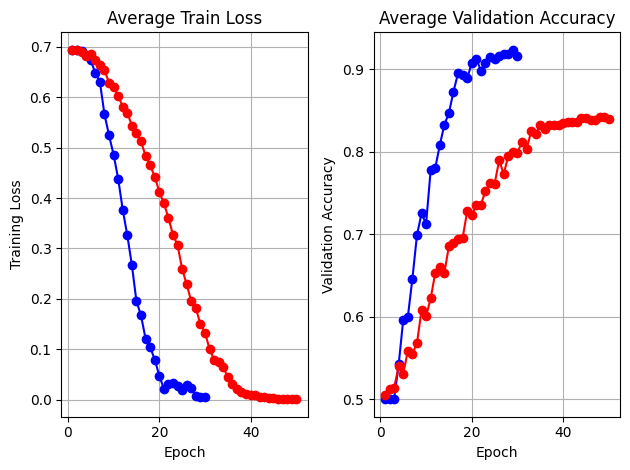

In [25]:
#CBAM
cbam_avg_train_loss = [sum(epoch)/len(epoch) for epoch in zip(*cbam_train_loss_tracker)]
cbam_avg_val_acc = [sum(epoch)/len(epoch) for epoch in zip(*cbam_val_acc_tracker)]
#CCNet
ccnet_avg_train_loss = [sum(epoch)/len(epoch) for epoch in zip(*ccnet_train_loss_tracker)]
ccnet_avg_val_acc = [sum(epoch)/len(epoch) for epoch in zip(*ccnet_val_acc_tracker)]

# Averged 3 Fold Loss Per Epoch
plt.subplot(1,2,1)  # 1 row, 2 columns, first plot
plt.plot(range(1, len(cbam_avg_train_loss)+1), cbam_avg_train_loss, marker='o', color='blue')
plt.plot(range(1, len(ccnet_avg_train_loss)+1), ccnet_avg_train_loss, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Average Train Loss")
plt.grid(True)

# Average 3 Fold Accuracy Per Epoch
plt.subplot(1,2,2)  # 1 row, 2 columns, second plot
plt.plot(range(1, len(cbam_avg_val_acc)+1), cbam_avg_val_acc, marker='o', color='blue')
plt.plot(range(1, len(ccnet_avg_val_acc)+1), ccnet_avg_val_acc, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Average Validation Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()



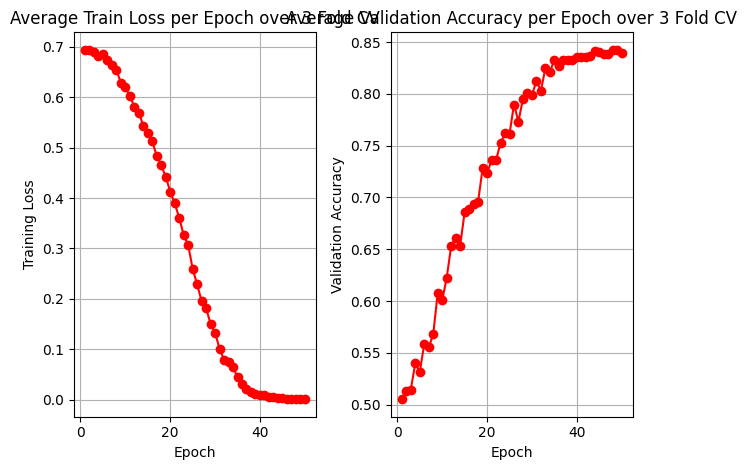

In [19]:
#CCNet
ccnet_avg_train_loss = [sum(epoch)/len(epoch) for epoch in zip(*ccnet_train_loss_tracker)]
ccnet_avg_val_acc = [sum(epoch)/len(epoch) for epoch in zip(*ccnet_val_acc_tracker)]

# Averged 3 Fold Loss Per Epoch
plt.subplot(1,2,1)  # 1 row, 2 columns, first plot
plt.plot(range(1, len(ccnet_avg_train_loss)+1), ccnet_avg_train_loss, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Average Train Loss per Epoch over 3 Fold CV")
plt.grid(True)

# Average 3 Fold Accuracy Per Epoch
plt.subplot(1,2,2)  # 1 row, 2 columns, second plot
plt.plot(range(1, len(ccnet_avg_val_acc)+1), ccnet_avg_val_acc, marker='o', color='red')
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Average Validation Accuracy per Epoch over 3 Fold CV")
plt.grid(True)

plt.tight_layout()
plt.show()



# Testing

In [27]:
cbam_model.eval()

predictions = []
probabilities = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      # raw logit
      logits = cbam_model(images)
      _, preds = torch.max(logits, 1)
      prob = torch.nn.functional.softmax(logits, dim=1)[:,1]

      predictions.extend(preds.cpu().numpy())
      probabilities.extend(prob.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())

# Test Metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
mcc = matthews_corrcoef(true_labels, predictions)

print("Test Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")


Test Metrics:
Accuracy:  0.9234
Precision: 0.9510
Recall:    0.8926
F1 Score:  0.9209
MCC:       0.8484


In [26]:
cc_net_model.eval()

ccnet_predictions = []
ccnet_probabilities = []
ccnet_true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      # raw logit
      logits = cc_net_model(images)
      _, preds = torch.max(logits, 1)
      prob = torch.nn.functional.softmax(logits, dim=1)[:,1]

      ccnet_predictions.extend(preds.cpu().numpy())
      ccnet_probabilities.extend(prob.cpu().numpy())
      ccnet_true_labels.extend(labels.cpu().numpy())

# Test Metrics
ccnet_accuracy = accuracy_score(ccnet_true_labels, ccnet_predictions)
ccnet_precision = precision_score(ccnet_true_labels, ccnet_predictions)
ccnet_recall = recall_score(ccnet_true_labels, ccnet_predictions)
ccnet_f1 = f1_score(ccnet_true_labels, ccnet_predictions)
ccnet_mcc = matthews_corrcoef(ccnet_true_labels, ccnet_predictions)

print("Test Metrics:")
print(f"Accuracy:  {ccnet_accuracy:.4f}")
print(f"Precision: {ccnet_precision:.4f}")
print(f"Recall:    {ccnet_recall:.4f}")
print(f"F1 Score:  {ccnet_f1:.4f}")
print(f"MCC:       {ccnet_mcc:.4f}")


Test Metrics:
Accuracy:  0.8851
Precision: 0.9313
Recall:    0.8313
F1 Score:  0.8784
MCC:       0.7747


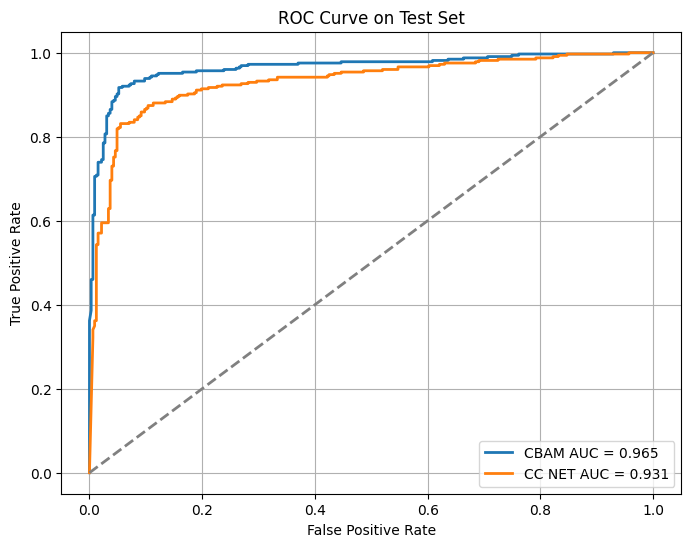

In [28]:
# ROC Curve
# copy to memory
#cbam
labels_np = true_labels.cpu().numpy() if torch.is_tensor(true_labels) else true_labels
probabilities_np = probabilities.cpu().numpy() if torch.is_tensor(probabilities) else probabilities
false_positive, true_positive, threshold = roc_curve(labels_np, probabilities_np)
roc_auc = auc(false_positive, true_positive)

#ccnet
ccnet_labels_np = ccnet_true_labels.cpu().numpy() if torch.is_tensor(ccnet_true_labels) else ccnet_true_labels
ccnet_probabilities_np = ccnet_probabilities.cpu().numpy() if torch.is_tensor(ccnet_probabilities) else ccnet_probabilities
ccnet_false_positive, ccnet_true_positive, ccnet_threshold = roc_curve(ccnet_labels_np, ccnet_probabilities_np)
ccnet_roc_auc = auc(ccnet_false_positive, ccnet_true_positive)

plt.figure(figsize=(8,6))
plt.plot(false_positive, true_positive, lw=2, label=f'CBAM AUC = {roc_auc:.3f}')
plt.plot(ccnet_false_positive, ccnet_true_positive, lw=2, label=f'CC NET AUC = {ccnet_roc_auc:.3f}')
plt.plot([0,1],[0,1], color='gray', linestyle='--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [23]:
print(len(labels_np), len(probabilities_np))
print(len(ccnet_labels_np), len(ccnet_probabilities_np))
print(np.unique(ccnet_labels_np), np.unique(labels_np))


653 653
653 653
[0 1] [0 1]
